In [2]:
import PyHeston # The PyHeston package must be installed.
import numpy
import itertools

from BlackScholes import *
from random import Random
from numpy import *
from scipy import *
from time import *
from datetime import *
import numpy as np
import sys
import csv
import math

from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF

import matplotlib.pyplot as plt
plt.style.use('ggplot')
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import scipy as sp
#from heston import * 

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
nInt = 1024
r0 = 0.0002
S= 100
K = 100
#T = 0.01
r = r0
sigma = 0.1 #0.6
lmbda = 0.1
meanV = 0.1
v0 = 0.1
rho =-0.9
T = 2.0

In [4]:
training_number = 30 # change training size 
testing_number = 40   #use all data as test, otherwise shape not match


x1_train = np.array(np.linspace(0.0,1.0, training_number), dtype='float32').reshape(training_number, 1)
x2_train = np.array(np.linspace(0.05,1.0, training_number), dtype='float32').reshape(training_number, 1)


X1_train, X2_train = np.meshgrid(x1_train, x2_train)
x_train = np.zeros(len(X1_train.flatten())*2).reshape(len(X2_train.flatten()), 2)
x_train[:,0] = X1_train.flatten()
x_train[:,1] = X2_train.flatten()

In [5]:

#x1_test = torch.linspace(0, 1.0, testing_number)
#x2_test = torch.linspace(0.05, 1.0, testing_number)
x1_test = np.array(np.linspace(0.0,1.0, testing_number), dtype='float32').reshape(testing_number, 1)
x2_test = np.array(np.linspace(0.05,1.0, testing_number), dtype='float32').reshape(testing_number, 1)

X1_test, X2_test = np.meshgrid(x1_test, x2_test)

x_test = np.zeros(len(X1_test.flatten())*2).reshape(len(X2_test.flatten()), 2)
x_test[:,0] = X1_test.flatten()
x_test[:,1] = X2_test.flatten()

In [6]:
nt = 11
timegrid = np.array(np.linspace(0.0,T,nt), dtype='float32').reshape(nt, 1)

In [7]:
def trainGPs(x_train, f, timegrid):

    gps = []
    i = 0
    for time in timegrid:
        print(time)
        
        y_train = []
        
        for idx in range(len(x_train)):
            #y_train.append(PyHeston.HestonCall(lb+interval*x_train[idx,0], x_train[idx,1], K, time, r, lmbda, meanV, sigma, rho, 0.4))
            y_train.append(f(x_train[idx,0], x_train[idx,1], time))
        y_train = np.array(y_train)
    
        
        sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(0.01, 100.0))  #100000.0
        gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20)
        gp.fit(x_train,y_train)
        gps.append(gp)
        i += 1
    return gps   

In [8]:
def predictGPs(x_test, f, gps, timegrid):
    
    preds = []
    stds = []
    y_tests = []
    i = 0
    for time in timegrid:
        
        y_test_= []
        for idx in range(len(x_test)):
                
            #y_train.append(PyHeston.HestonCall(lb+interval*x_train[idx,0], x_train[idx,1], K, time, r, lmbda, meanV, sigma, rho, 0.4))
            y_test_.append(f(x_test[idx,0], x_test[idx,1], time))
            
        print(len(x_test), len(y_test_))
        y_test = np.array(y_test_)
        y_tests.append(y_test)
        
        # Find optimal model hyperparameters
        # Set into eval mode
        pred, std = gps[i].predict(x_test,return_std=True)
        preds.append(pred)
        stds.append(std)
        i+=1
    return y_tests, preds, stds 

In [9]:
lb = 1
ub = 400
portfolio = {}
portfolio['call']={}
portfolio['put']={}

portfolio['call']['price']= lambda x,y,z: PyHeston.HestonCall(lb+(ub-lb)*x, y, K, z, r, lmbda, meanV, sigma, rho, 0.4)
portfolio['put']['price']= lambda x,y,z: PyHeston.HestonPut(lb+(ub-lb)*x, y, K, z, r, lmbda, meanV, sigma, rho, 0.4)

In [ ]:
for key in portfolio.keys():
    portfolio[key]['GPs'] = trainGPs(x_train, portfolio[key]['price'], timegrid)
    portfolio[key]['y_tests'], portfolio[key]['preds'], portfolio[key]['sigmas'] = predictGPs(x_test, portfolio[key]['price'], portfolio[key]['GPs'], timegrid)

[0.]


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-8.27282331]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-12.05142684]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 73, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)


[0.2]


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-366.1731698]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-17.71348198]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 72, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.0336636]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 80, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/g

[0.4]


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-45.59273056]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 87, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-17.94817497]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 75, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.54921035]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 137, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_proces

[0.6]


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-397.47746617]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.56536889]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 72, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.04018092]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 70, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/

[0.8]


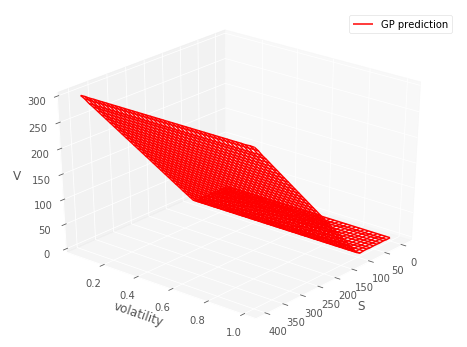

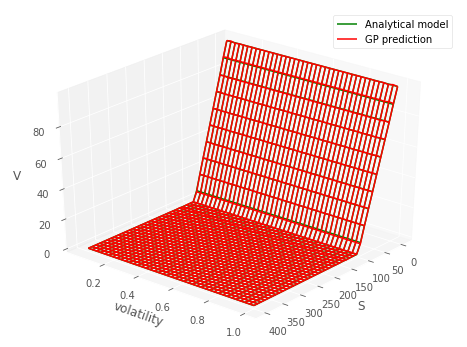

In [21]:
# plot the GP versus the testing data for any point on the timegrid
res = testing_number


x1_plot=lb+(ub-lb)*x_test[:,0].reshape(res,res)
x2_plot=x_test[:,1].reshape(res,res)



pred_plot  =  portfolio['call']['preds'][0].reshape(res,res) 
test_plot = portfolio['call']['y_tests'][0].reshape(res,res) 

#p
ax.set_xlabel('S')
ax.set_ylabel('volatility')
ax.set_zlabel('V')
ax.legend(loc = 'best', prop={'size':10})


x1_plot=lb+(ub-lb)*x_test[:,0].reshape(res,res)
x2_plot=x_test[:,1].reshape(res,res)

pred_plot  =  portfolio['put']['preds'][0].reshape(res,res) 
test_plot = portfolio['put']['y_tests'][0].reshape(res,res) 


#pred_plot  =  np.array(preds[0].mean()[:,1].reshape(res,res)) #  portfolio['call']['preds'][0].reshape(res,res) 
#test_plot = portfolio['call']['y_tests'][0].reshape(res,res)
#test_plot = np.array(y_tests[0][:,1].reshape(res,res))
#plt.subplot(1, 2, 2)
plt.figure(figsize = (8, 6), facecolor='white', edgecolor='black')

plt.rcParams['axes.facecolor'] = 'white'
ax = plt.axes(projection='3d')

angle = 40
ax.view_init(30, angle)
ax.plot_wireframe(x1_plot, x2_plot, test_plot, color='green', label = 'Analytical model')
ax.plot_wireframe(x1_plot, x2_plot, pred_plot, color='red', label='GP prediction' )
ax.set_xlabel('S')
ax.set_ylabel('volatility')
ax.set_zlabel('V')
ax.legend(loc = 'best', prop={'size':10})

    #plt.draw()
#plt.pause(.001)